In [71]:
# https://dining-developer.tistory.com/30
# seaborn 시각화 방법

In [ ]:
# How I made top 0.3% on a Kaggle competition

https://www.kaggle.com/code/lavanyashukla01/how-i-made-top-0-3-on-a-kaggle-competition

In [144]:
import numpy as np
import pandas as pd
import datetime
import random
import os
import sys

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import scale, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings(action = 'ignore')
pd.options.display.max_seq_items = 100
pd.options.display.max_rows = 100

In [103]:
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

print(f'train_df.shape = {train_df.shape}')
print(f'test_df.shape = {test_df.shape}')

train_df.shape = (1460, 81)
test_df.shape = (1459, 80)


# EDA

### 데이터 분포 확인

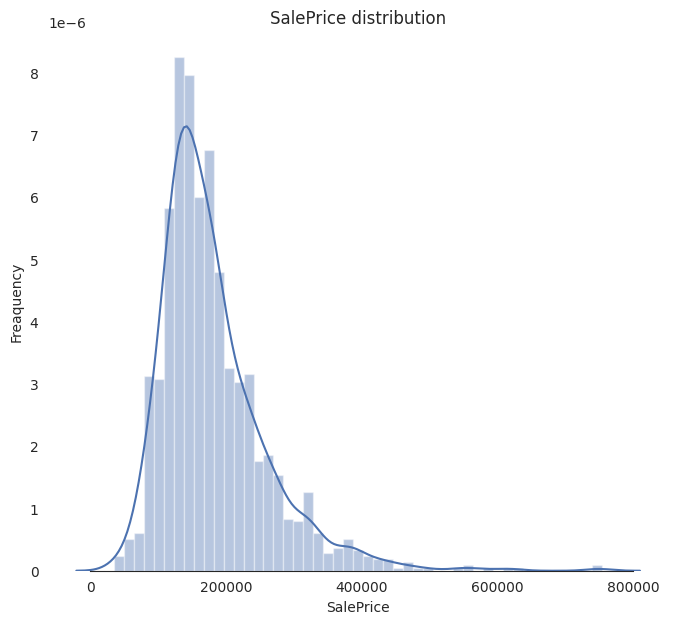

In [10]:
sns.set_style('white')
sns.set_color_codes(palette = 'deep')

f, ax = plt.subplots(figsize = (8, 7))
sns.distplot(train_df['SalePrice'], color = 'b')
ax.xaxis.grid(False)
ax.set(ylabel = 'Freaquency')
ax.set(xlabel = 'SalePrice')
ax.set(title = 'SalePrice distribution')
sns.despine(trim = True, left = True)

plt.show()

In [104]:
print(f"Skewness: {train_df['SalePrice'].skew():.4f}")
print(f"Kurtosis: {train_df['SalePrice'].kurt():.4f}")

Skewness: 1.8829
Kurtosis: 6.5363


In [105]:
len(numeric)

38

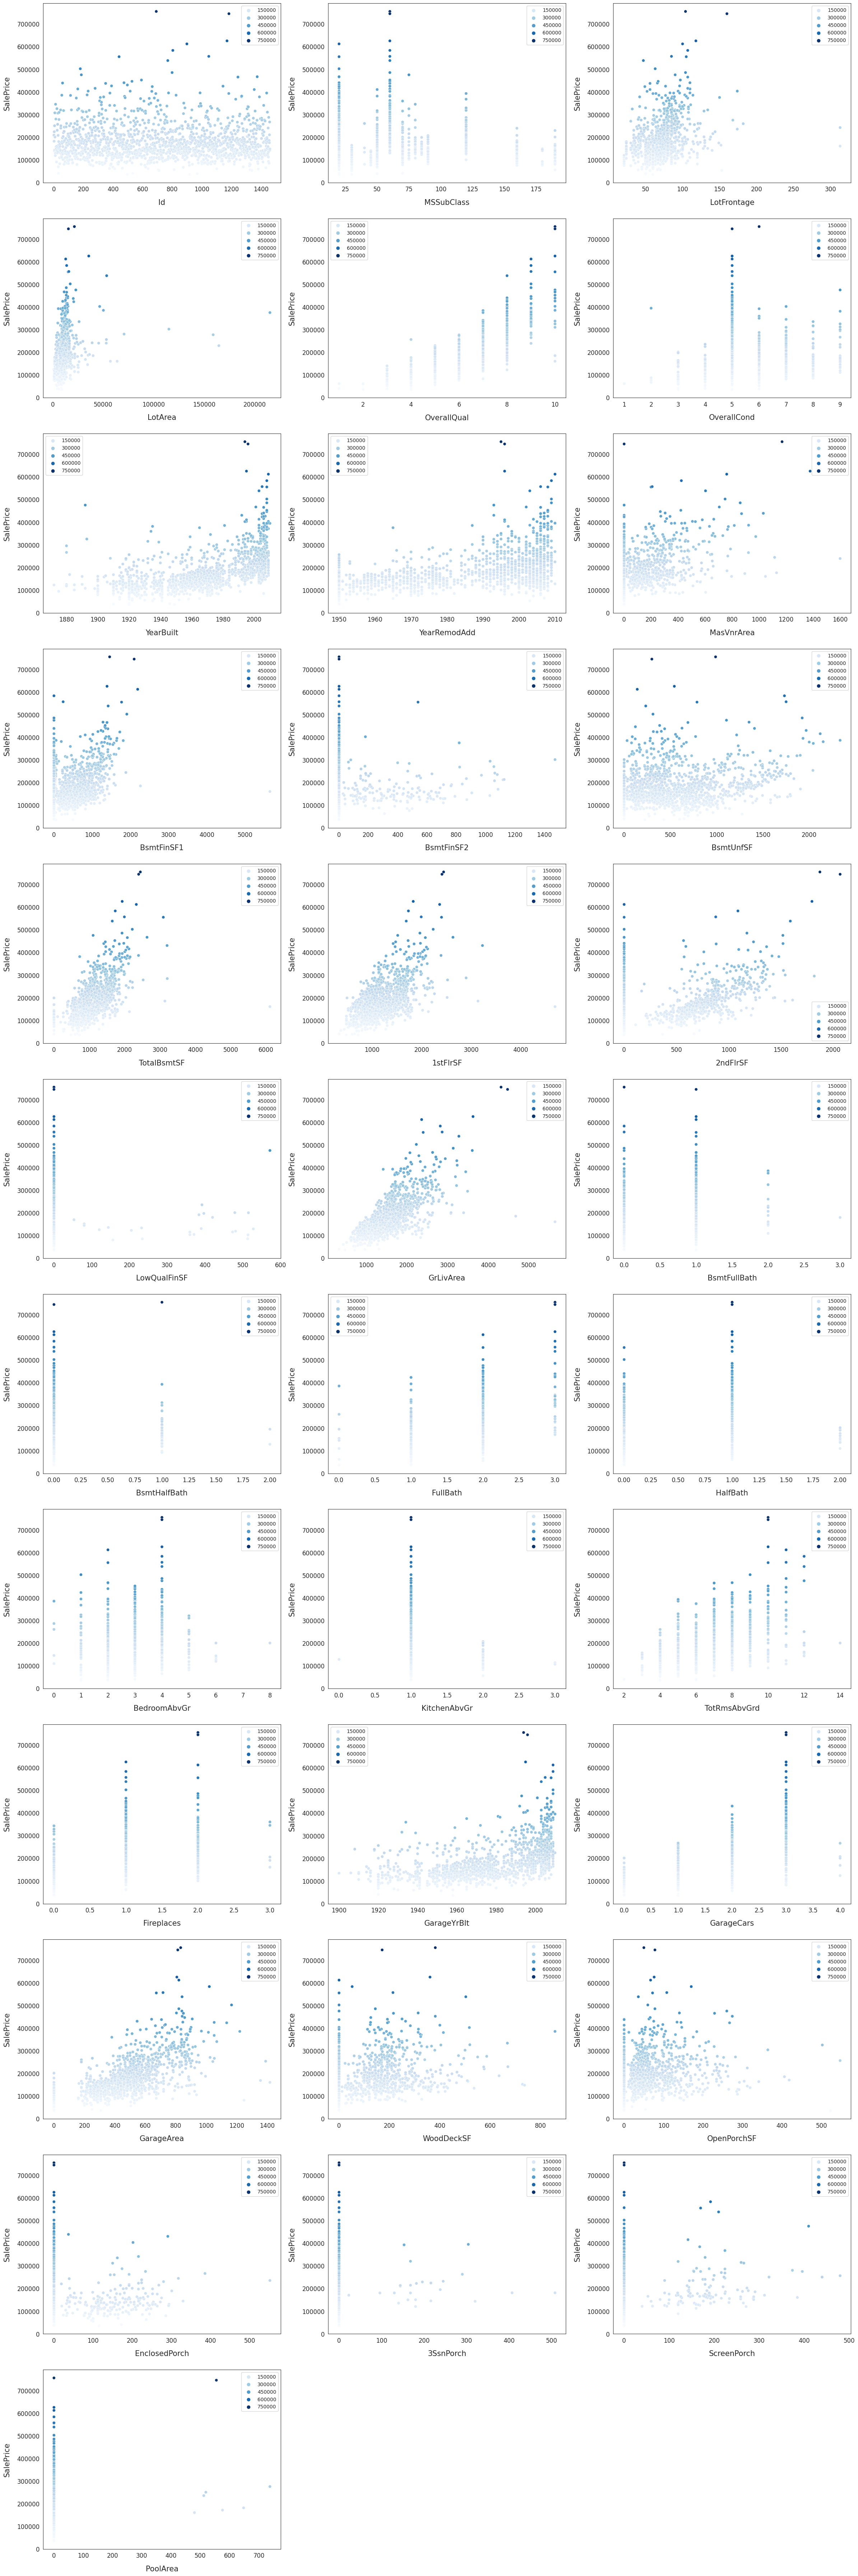

In [27]:
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []

for i in train_df.columns:
    if train_df[i].dtype in numeric_dtypes:
        if i in ['TotalSF', 'Total_Bathrooms', 'Total_porch_sf', 'haspool', 'hasgarage', 'hasbmst', 'hasfireplace']:
            pass
        else:
            numeric.append(i)

fig, axes = plt.subplots(figsize = (12, 120))

plt.subplots_adjust(right = 2)
plt.subplots_adjust(top = 2)
sns.color_palette('husl', 8)

for i, feature in enumerate(list(train_df[numeric]), 1):
    if (feature == 'MiscVal'):
        break
    plt.subplot(len(list(numeric)), 3, i)
    sns.scatterplot(x = feature, y = 'SalePrice', hue = 'SalePrice', palette = 'Blues', data = train_df)
    plt.xlabel(f'{feature}', size = 15, labelpad = 12.5)
    plt.ylabel('SalePrice', size = 15, labelpad = 12.5)
    
    for j in range(2):
        plt.tick_params(axis = 'x', labelsize = 12)
        plt.tick_params(axis = 'y', labelsize = 12)
        
    plt.legend(loc = 'best', prop = {'size': 10})
    
plt.show()

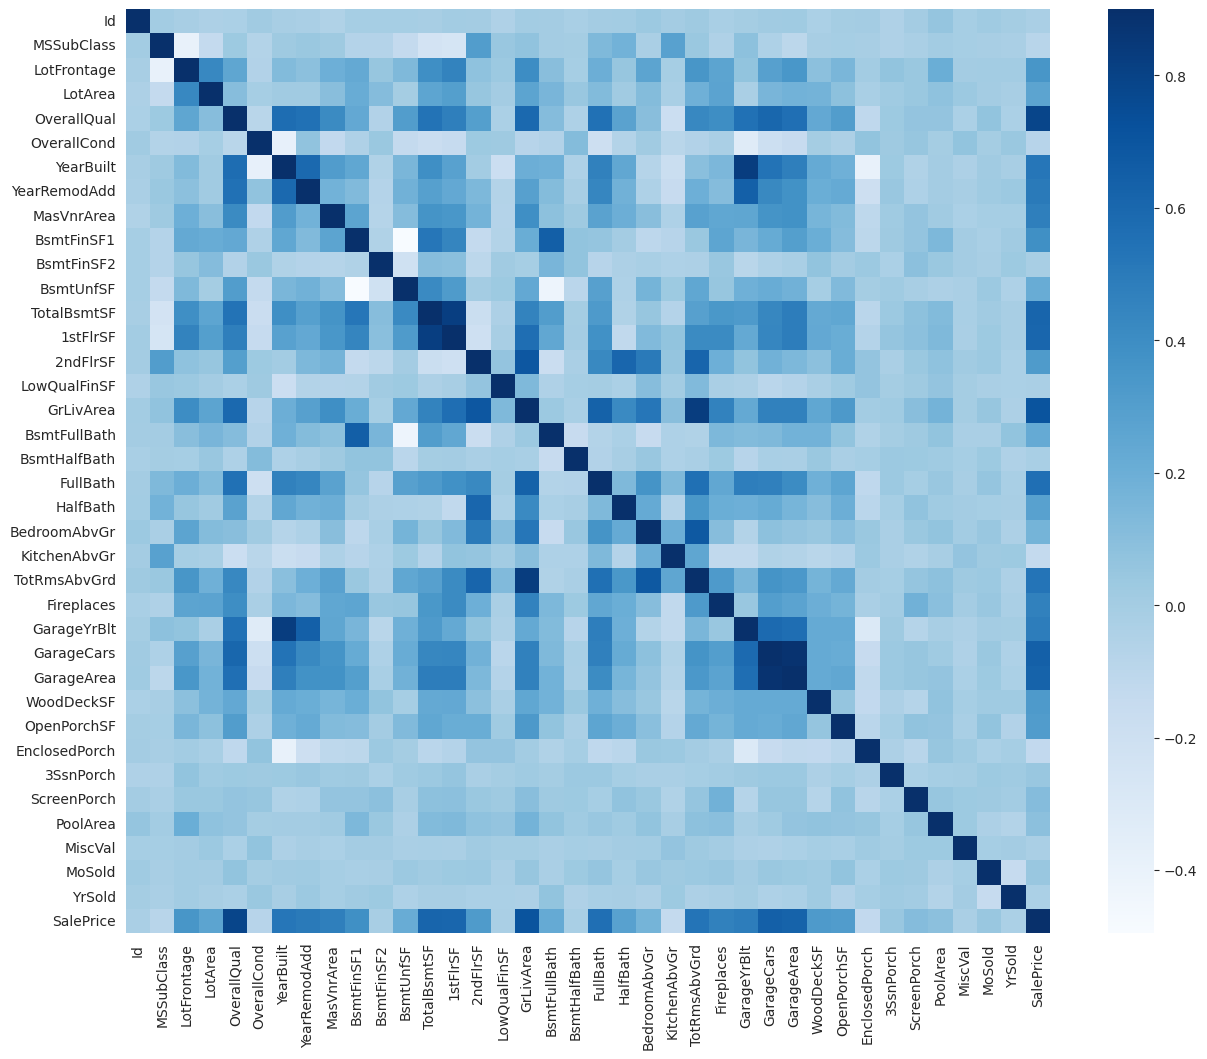

In [30]:
corr = train_df.corr()

plt.subplots(figsize = (15, 12))
sns.heatmap(corr, vmax = 0.9, cmap = 'Blues', square = True)

plt.show()

(-0.5, 9.5, 0.0, 800000.0)

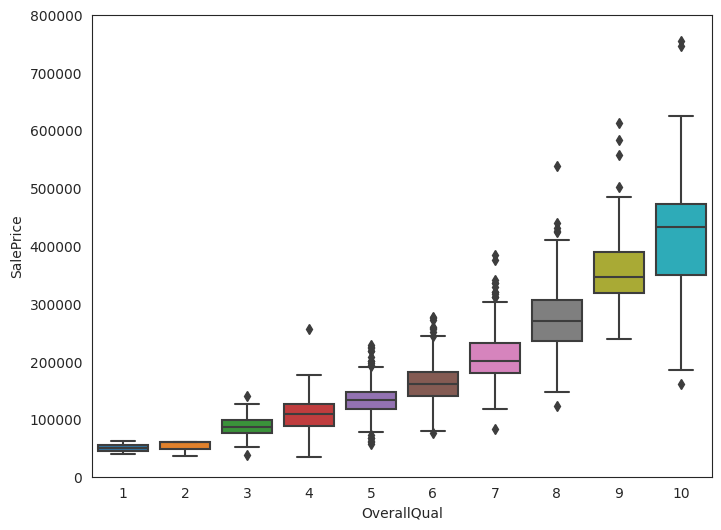

In [34]:
# boxplot을 통한 데이터 분포 확인 및 outlier 확인

data = pd.concat([train_df['SalePrice'], train_df['OverallQual']], axis = 1)

f, ax = plt.subplots(figsize = (8, 6))

fig = sns.boxplot(x = train_df['OverallQual'],
                  y = 'SalePrice',
                  data = data)
fig.axis(ymin = 0, ymax = 800000)

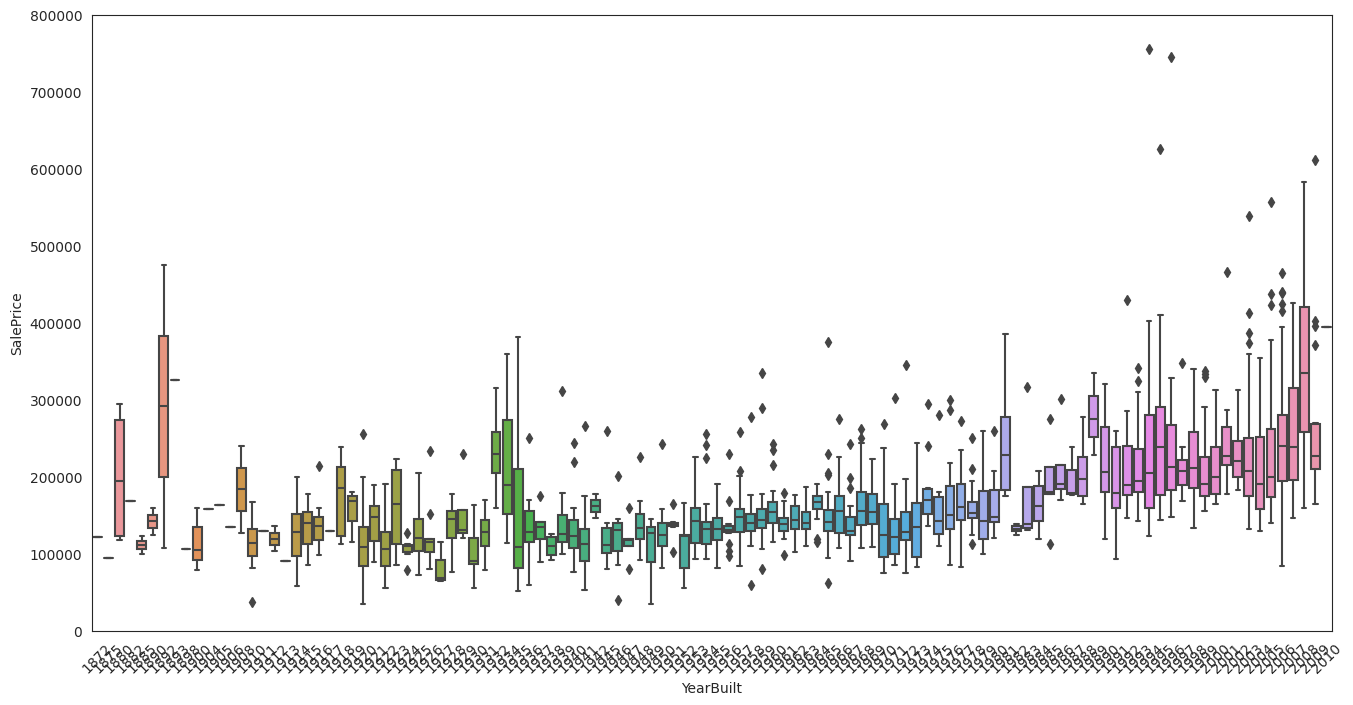

In [38]:
data = pd.concat([train_df['SalePrice'],
                  train_df['YearBuilt']], axis = 1)

f, ax = plt.subplots(figsize = (16, 8))
fig = sns.boxplot(x = train_df['YearBuilt'], y = 'SalePrice', data = data)
fig.axis(ymin = 0, ymax = 800000)

plt.xticks(rotation = 45)

plt.show()

In [54]:
train_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,...,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,...,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,...,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,G

In [106]:
print(f'''
    Before Dropping ID
    train_df.shape = {train_df.shape}
    test_df.shape = {test_df.shape}
''')

train_ID = train_df['Id']
test_ID = test_df['Id']

train_df.drop(columns = ['Id'], inplace = True)
test_df.drop(columns = ['Id'], inplace = True)

print(f'''
    After Dropping ID
    train_df.shape = {train_df.shape}
    test_df.shape = {test_df.shape}
''')


    Before Dropping ID
    train_df.shape = (1460, 81)
    test_df.shape = (1459, 80)


    After Dropping ID
    train_df.shape = (1460, 80)
    test_df.shape = (1459, 79)



# Feature Engineering

기본적인 feature engineering의 개념과 방법
- 데이터의 분포를 확인하고, 정규분포에 가까운 형태로 변형이 가능하다면 변형을 주도록 한다. (ex. 로그 변환)
- 데이터의 분포를 확인하고, 아웃라이어 값 & 널 값에 대한 처리를 진행한다. (널 값 채우기, 아웃라이어 삭제하기 등)
- 데이터 분석을 통해 새로운 특성을 생성

### 데이터 변환

In [56]:
# Label 값이 되는 SalePrice의 분포를 확인해보자

sns.set_style('white')

In [ ]:
fig = sns.displot(data=dfl, x='vals', col='bill_size', kde=True, stat='density', bins=12, height=4, facet_kws={'sharey': False, 'sharex': False})
plt.show()

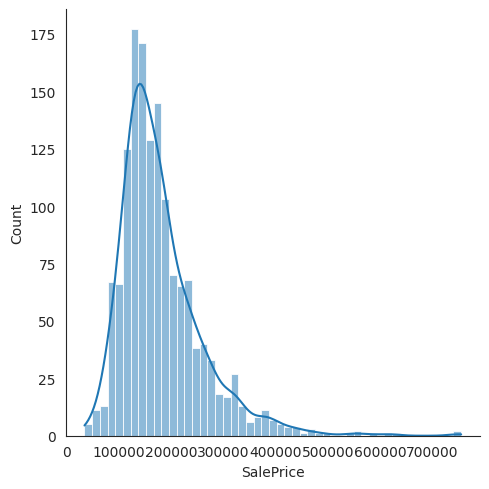

In [73]:
sns.displot(train_df['SalePrice'], kde = True) # kde (Kernel Density Estimation 커널 밀도 추정)

In [78]:
# 그래프를 보면 데이터의 분포가 왼쪽으로 쏠려있는 것을 확인할 수 있다. (skew > 0)
# 이런 경우 로그 변환을 시도해볼만 하다.

# 간단한 왜도의 계산 -> 피어슨의 비대칭 계수: (평균 - 최빈값) / 표준 편차
# 최빈 값이 평균보다 크면, 음수가 나온다 -> 최빈 값이 평균보다 크다는 건 데이터가 오른쪽으로 많이 쏠려 있다는 것
# 최반 값이 평균보다 작으면, 양수가 나온다 > 최반 값이 평균보다 작다는 건 데이터가 왼쪽으로 많이 쏠려 있다는 것

In [110]:
train_df['SalePrice_log'] = np.log1p(train_df['SalePrice'])


 mu = 12.02 and sigma = 0.40



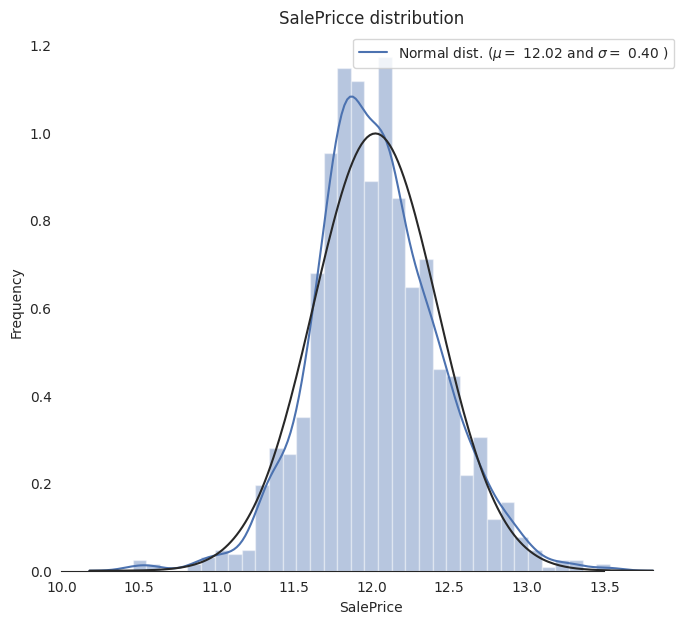

In [191]:
sns.set_style('white')
sns.set_color_codes(palette = 'deep')

f, ax = plt.subplots(figsize = (8, 7))
sns.distplot(train_df['SalePrice_log'],
             fit = norm,
             color = 'b')

(mu, sigma) = norm.fit(train_df['SalePrice_log'])
print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
ax.set(ylabel = 'Frequency')
ax.set(xlabel = 'SalePrice')
ax.set(title = 'SalePricce distribution')
sns.despine(trim = True, left = True)

plt.show()

### 아웃라이어 제거

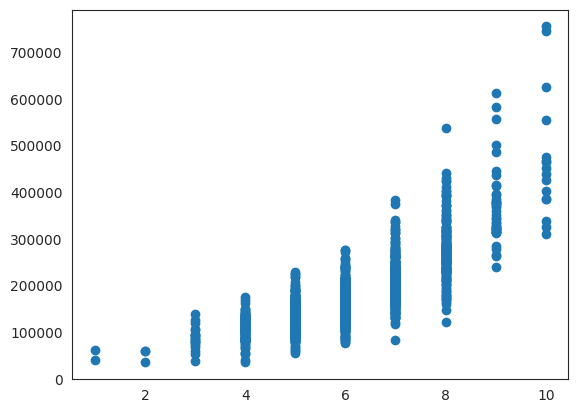

In [189]:
plt.scatter(train_df['OverallQual'],
            train_df['SalePrice'])

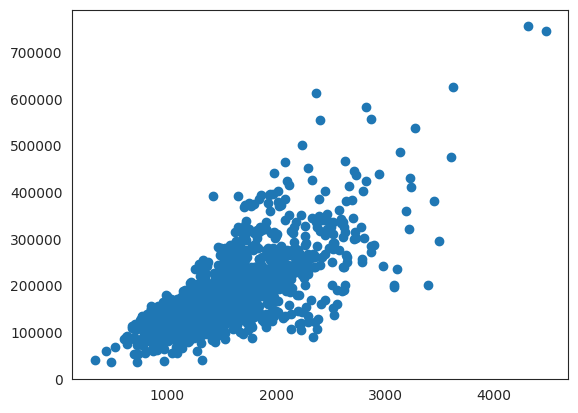

In [188]:
plt.scatter(train_df['GrLivArea'],
            train_df['SalePrice'])

# plt.scatter([4676, 5642], [184750, 160000], marker = '*', color = 'red', s = 100)

In [192]:
# data frame의 메서드 중 drop을 통해 삭제하고자 하는 인덱스 값을 입력하면, 해당 row의 데이터가 삭제된다.
train_df.drop(train_df.loc[(train_df['OverallQual'] < 5) & (train_df['SalePrice'] > 200000)].index, inplace = True)
train_df.drop(train_df.loc[(train_df['GrLivArea'] > 4500) & (train_df['SalePrice'] < 200000)].index, inplace = True)
train_df.reset_index(drop = True, inplace = True)

In [193]:
train_df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,...,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,SalePrice_log
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,...,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,12.247699
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,...,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,12.109016
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,...,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,12.317171
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,...,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,11.849405
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,...,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,12.429220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1452,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,...,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000,12.072547
1453,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,...,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000,12.254868
1454,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,...,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500,12.493133
1455,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,Met

In [182]:
y_train = train_df['SalePrice'].reset_index(drop = True)
X_train = train_df.drop(['SalePrice'], axis = 1)

X_test = test_df

In [330]:
X_all = pd.concat([X_train, X_test]).reset_index(drop = True)
print(X_all.shape)

(2916, 80)


In [331]:
train_df.shape, test_df.shape

((1457, 81), (1459, 79))

In [332]:
def percent_missing(df):
    df_cols = list(df.columns)
    dic_x = {}
    
    for i in range(0, len(df_cols)):
        dic_x.update(
                        {df_cols[i]: round(df[df_cols[i]].isnull().mean() * 100, 2)}
        )
        # dict의 update 메서드를 이용하면, 기존에 없었던 키값에 대해서는 데이터를 추가하고,
        # 있었던 키값에 대해서는 데이터를 업데이트할 수 있다.
        
    return dic_x

In [333]:
missing = percent_missing(X_all)
miss_df = sorted(missing.items(), key = lambda x: x[1], reverse = True)

print('Percent of missing data')
display(miss_df[:10])

Percent of missing data


[('PoolQC', 99.69),
 ('MiscFeature', 96.4),
 ('Alley', 93.21),
 ('Fence', 80.42),
 ('SalePrice_log', 50.03),
 ('FireplaceQu', 48.7),
 ('LotFrontage', 16.63),
 ('GarageYrBlt', 5.45),
 ('GarageFinish', 5.45),
 ('GarageQual', 5.45)]

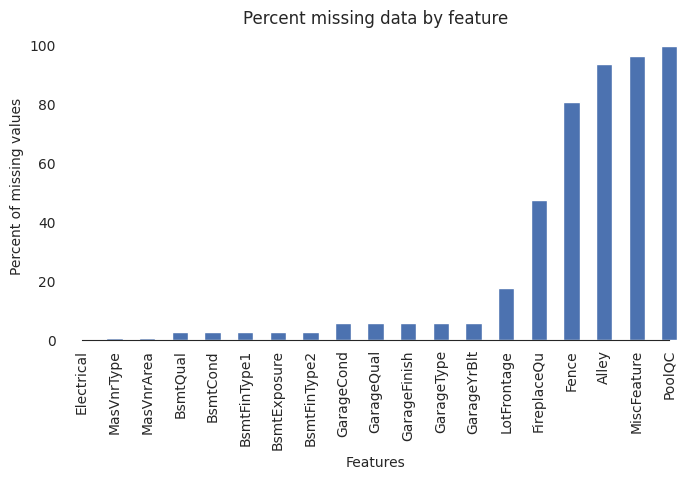

In [334]:
sns.set_style('white')

fig, ax = plt.subplots(figsize = (8, 4))
sns.set_color_codes(palette = 'deep')
missing = round(train_df.isnull().mean() * 100, 2)
missing = missing[missing > 0]
missing.sort_values(inplace = True)
missing.plot.bar(color = 'b')

ax.xaxis.grid(False)
ax.set(ylabel = 'Percent of missing values')
ax.set(xlabel = 'Features')
ax.set(title = 'Percent missing data by feature')
sns.despine(trim = True, left = True)

In [335]:
X_all['MSSubClass'] = X_all['MSSubClass'].astype(str)
X_all['YrSold'] = X_all['YrSold'].astype(str)
X_all['MoSold'] = X_all['MoSold'].astype(str)

In [336]:
'''
손실된 데이터에 대한 처리

각 컬럼에 대해서, null 값을 어떤 값으로 처리할 것인지를 결정해야한다.
이는 데이터에 대한 이해가 필요한 부분으로, 데이터 분석작업이 코딩만으로 끝나지 않는 이유이다.

일반적으로는 해당 특성에서 가장 많이 나타나는 값으로 빈 값을 채운다.
'''

def handle_missing(df):
    df['Functional'] = df['Functional'].fillna('Typ')

In [337]:
X_all['Functional'].value_counts()

Typ     2715
Min2      70
Min1      64
Mod       35
Maj1      19
Maj2       9
Sev        2
Name: Functional, dtype: int64

In [338]:
X_all['Electrical'].value_counts()

SBrkr    2668
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64

In [339]:
X_all['KitchenQual'].value_counts()

TA    1492
Gd    1150
Ex     203
Fa      70
Name: KitchenQual, dtype: int64

In [340]:
X_all['Exterior1st'].value_counts()
# X_all['Exterior1st'].value_counts().plot(kind = 'bar')

VinylSd    1025
MetalSd     450
HdBoard     442
Wd Sdng     411
Plywood     220
CemntBd     125
BrkFace      87
WdShing      56
AsbShng      44
Stucco       42
BrkComm       6
AsphShn       2
Stone         2
CBlock        2
ImStucc       1
Name: Exterior1st, dtype: int64

In [341]:
X_all['Exterior2nd'].value_counts()

VinylSd    1014
MetalSd     447
HdBoard     406
Wd Sdng     391
Plywood     269
CmentBd     125
Wd Shng      81
BrkFace      47
Stucco       46
AsbShng      38
Brk Cmn      22
ImStucc      15
Stone         6
AsphShn       4
CBlock        3
Other         1
Name: Exterior2nd, dtype: int64

In [342]:
X_all['SaleType'].value_counts(), print(X_all['SaleType'].mode())

0    WD
Name: SaleType, dtype: object


(WD       2524
 New       237
 COD        87
 ConLD      26
 CWD        12
 ConLI       9
 ConLw       8
 Oth         7
 Con         5
 Name: SaleType, dtype: int64,
 None)

In [343]:
X_all['MSZoning'].value_counts(), print(X_all['MSZoning'].mode())

0    RL
Name: MSZoning, dtype: object


(RL         2262
 RM          460
 FV          139
 RH           26
 C (all)      25
 Name: MSZoning, dtype: int64,
 None)

In [344]:
# 전체 데이터셋이 아닌, 특정 그룹별로 value_counts를 진행하여, 최빈 값으로 널값을 채우는 방식
# 그룹별로 다른 패턴이 나타나는 특성의 경우, 이 방법을 고려할 필요가 있다.
X_all.groupby(['MSSubClass'])['MSZoning'].value_counts()

MSSubClass  MSZoning
120         RL           117
            RM            40
            FV            19
            RH             6
150         RL             1
160         RM            64
            FV            43
            RL            21
180         RM            17
190         RL            31
            RM            23
            RH             4
            C (all)        3
20          RL          1015
            FV            34
            RM            20
            RH             4
            C (all)        3
30          RM            67
            RL            61
            C (all)        8
            RH             2
40          RL             4
            RM             2
45          RM            11
            RL             6
            RH             1
50          RL           159
            RM           119
            C (all)        7
            RH             2
60          RL           527
            FV            43
            RM        

In [345]:
X_all['PoolQC'].value_counts()

Ex    4
Gd    3
Fa    2
Name: PoolQC, dtype: int64

In [346]:
cols = ['GarageYrBlt', 'GarageArea', 'GarageCars', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
        'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']

for col in cols:
    print(col)
    print(X_all[col].value_counts(), '\n')

GarageYrBlt
2005.0    142
2006.0    115
2007.0    114
2004.0     99
2003.0     92
         ... 
1908.0      1
1896.0      1
1933.0      1
1906.0      1
1919.0      1
Name: GarageYrBlt, Length: 103, dtype: int64 

GarageArea
0.0       157
576.0      97
440.0      96
240.0      69
484.0      68
         ... 
1025.0      1
923.0       1
192.0       1
708.0       1
272.0       1
Name: GarageArea, Length: 602, dtype: int64 

GarageCars
2.0    1592
1.0     776
3.0     373
0.0     157
4.0      16
5.0       1
Name: GarageCars, dtype: int64 

GarageType
Attchd     1721
Detchd      779
BuiltIn     185
Basment      36
2Types       23
CarPort      15
Name: GarageType, dtype: int64 

GarageFinish
Unf    1230
RFn     811
Fin     716
Name: GarageFinish, dtype: int64 

GarageQual
TA    2601
Fa     124
Gd      24
Po       5
Ex       3
Name: GarageQual, dtype: int64 

GarageCond
TA    2651
Fa      74
Gd      15
Po      14
Ex       3
Name: GarageCond, dtype: int64 

BsmtQual
TA    1283
Gd    1208
Ex     

In [347]:
def handle_missing(df):
    # 각 컬럼의 빈 값을 무슨 값으로 채워야할 것인지에 대해서 정의 및 분석을 통해 결정해야한다.
    df['Functional'] = df['Functional'].fillna('Typ')

    df['Electrical'] = df['Electrical'].fillna("SBrkr")
    df['KitchenQual'] = df['KitchenQual'].fillna("TA")
    df['Exterior1st'] = df['Exterior1st'].fillna(df['Exterior1st'].mode()[0])
    df['Exterior2nd'] = df['Exterior2nd'].fillna(df['Exterior2nd'].mode()[0])
    df['SaleType'] = df['SaleType'].fillna(df['SaleType'].mode()[0])
    df['MSZoning'] = df.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
    
    df["PoolQC"] = df["PoolQC"].fillna("None")

    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
        df[col] = df[col].fillna(0)

    for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
        df[col] = df[col].fillna('None')

    for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
        df[col] = df[col].fillna('None')
        
    df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

    objects = []
    for i in df.columns:
        if df[i].dtype == object:
            objects.append(i)
    df.update(df[objects].fillna('None'))
        
    # And we do the same thing for numerical features, but this time with 0s
    numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numeric = []
    for i in df.columns:
        if df[i].dtype in numeric_dtypes:
            numeric.append(i)
    
    df.update(df[numeric].fillna(0))    
    
    return df

In [348]:
X_all = handle_missing(X_all)

In [349]:
missing = percent_missing(X_all)
miss_df = sorted(missing.items(), key = lambda x: x[1], reverse = True)

print('Percent of missing data')
display(miss_df[:10])

Percent of missing data


[('MSSubClass', 0.0),
 ('MSZoning', 0.0),
 ('LotFrontage', 0.0),
 ('LotArea', 0.0),
 ('Street', 0.0),
 ('Alley', 0.0),
 ('LotShape', 0.0),
 ('LandContour', 0.0),
 ('Utilities', 0.0),
 ('LotConfig', 0.0)]

In [350]:
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []

for i in X_all.columns:
    if X_all[i].dtype in numeric_dtypes:
        numeric.append(i)

In [351]:
print(numeric)

['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice_log']


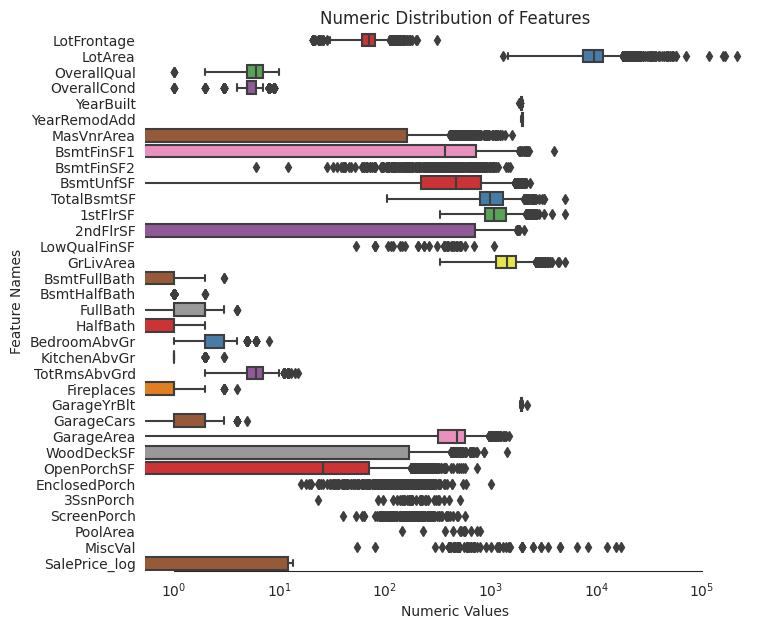

In [352]:
sns.set_style('white')

fig, ax = plt.subplots(figsize = (8, 7))
ax.set_xscale('log')
ax = sns.boxplot(data = X_all[numeric], orient = 'h', palette = 'Set1')
ax.xaxis.grid(False)
ax.set(ylabel = 'Feature Names')
ax.set(xlabel = 'Numeric Values')
ax.set(title = 'Numeric Distribution of Features')
sns.despine(trim = True, left = True)

In [353]:
skew_features = X_all[numeric].apply(lambda x: skew(x)).sort_values(ascending = False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print(f'There are {high_skew.shape[0]} numerical features with Skew > 0.5 :')
skewness = pd.DataFrame({'Skew': high_skew})
skew_features.head(10)

There are 25 numerical features with Skew > 0.5 :


MiscVal          21.935910
PoolArea         17.685603
LotArea          13.262550
LowQualFinSF     12.082427
3SsnPorch        11.370087
KitchenAbvGr      4.299698
BsmtFinSF2        4.143683
EnclosedPorch     4.001570
ScreenPorch       3.944305
BsmtHalfBath      3.929197
dtype: float64

In [354]:
for i in skew_index:
    X_all[i] = boxcox1p(X_all[i], boxcox_normmax(X_all[i] + 1))

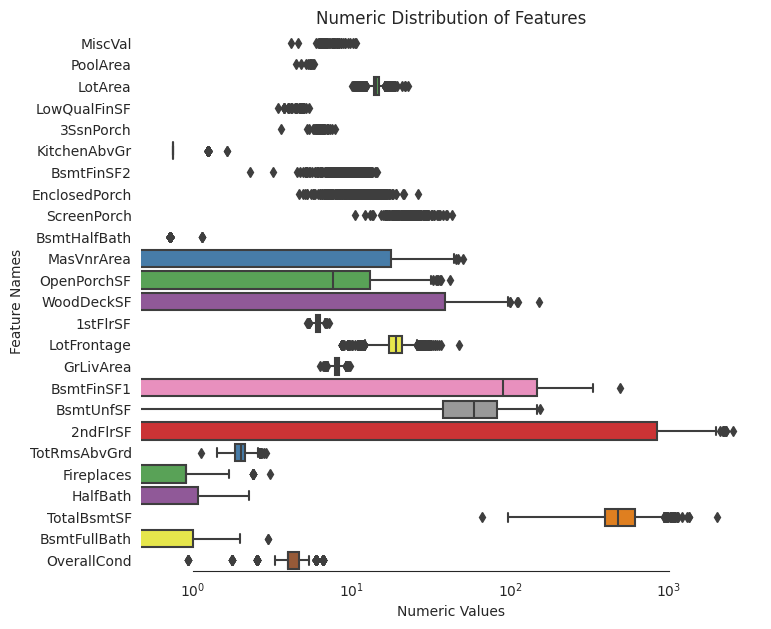

In [355]:
sns.set_style('white')

fig, ax = plt.subplots(figsize = (8, 7))
ax.set_xscale('log')
ax = sns.boxplot(data = X_all[skew_index], orient = 'h', palette = 'Set1')
ax.xaxis.grid(False)
ax.set(ylabel = 'Feature Names')
ax.set(xlabel = 'Numeric Values')
ax.set(title = 'Numeric Distribution of Features')
sns.despine(trim = True, left = True)

### Create interesting features

feature engineering 작업의 일환으로, 분석한 내용을 바탕으로 임의로 특성을 생성하여 컬럼을 추가하는 작업이다.

일반적으로,

1) 특성의 존재유무를 표현하는 0, 1 값을 가진 컬럼의 추가와
2) 특성값의 로그변환 or 지수변환

등의 방법이 사용된다.

In [364]:
X_all['BsmtFinType1_Unf'] = (X_all['BsmtFinType1'] == 'Unf') * 1
X_all['HasWoodDeck'] = (X_all['WoodDeckSF'] == 0) * 1
X_all['HasOpenPorch'] = (X_all['OpenPorchSF'] == 0) * 1
X_all['HasEnclosedPorch'] = (X_all['EnclosedPorch'] == 0) * 1
X_all['Has3SsnPorch'] = (X_all['3SsnPorch'] == 0) * 1
X_all['HasScreenPorch'] = (X_all['ScreenPorch'] == 0) * 1
X_all['YearSinceRemodel'] = X_all['YrSold'].astype(int) - X_all['YearRemodAdd'].astype(int)
X_all['Total_Home_Quality'] = X_all['OverallQual'] + X_all['OverallCond']
X_all = X_all.drop(['Utilities', 'Street', 'PoolQC'], axis = 1)
X_all['TotalSF'] = X_all['TotalBsmtSF'] + X_all['1stFlrSF'] + X_all['2ndFlrSF']
X_all['YrBltAndRemod'] = X_all['YearBuilt'] + X_all['YearRemodAdd']

X_all['Total_sqr_footage'] = (X_all['BsmtFinSF1'] + X_all['BsmtFinSF2'] + X_all['1stFlrSF'] + X_all['2ndFlrSF'])
X_all['Total_Bathrooms'] = (X_all['FullBath'] + (0.5 * X_all['HalfBath']) + X_all['BsmtFullBath'] + (0.5 * X_all['BsmtHalfBath']))
X_all['Total_porch_sf'] = (X_all['OpenPorchSF'] + X_all['3SsnPorch'] + X_all['EnclosedPorch'] + X_all['ScreenPorch'] + X_all['WoodDeckSF'])

X_all['TotalBsmtSF'] = X_all['TotalBsmtSF'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
X_all['2ndFlrSF'] = X_all['2ndFlrSF'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)
X_all['GarageArea'] = X_all['GarageArea'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
X_all['GarageCars'] = X_all['GarageCars'].apply(lambda x: 0 if x <= 0.0 else x)
X_all['LotFrotage'] = X_all['LotFrontage'].apply(lambda x: np.exp(4.2) if x <= 0.0 else x)
X_all['MasVnrArea'] = X_all['MasVnrArea'].apply(lambda x: np.exp(4) if x <= 0.0 else x)
X_all['BsmtFinSF1'] = X_all['BsmtFinSF1'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)

X_all['haspool'] = X_all['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
X_all['has2ndfloor'] = X_all['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
X_all['hasgarage'] = X_all['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
X_all['hasbsmt'] = X_all['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
X_all['hasfireplace'] = X_all['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [366]:
def logs(res, ls):
    m = res.shape[1]
    
    for l in ls:
        res = res.assign(newcol = pd.Series(np.log(1.01 + res[l])).values)
        res.columns.values[m] = l + '_log'
        m += 1
        
    return res

log_features = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
                'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
                'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
                'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'YearRemodAdd', 'TotalSF']

X_all = logs(X_all, log_features)